In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
dir = os.path.join('/content/drive/My Drive/mfds dataset/Images')  # directory of imageset

In [3]:
# lets create the separate image path for each image
c_files = os.listdir(dir)
img_dir = [os.path.join(dir, fname) for fname in c_files]
print(c_files)
print(img_dir[0])

['4.png', '6.png', '3.png', '0.png', '5.png', '7.png', '10.png', '8.png', '9.png', '1.png', '2.png', '25.png', '21.png', '29.png', '24.png', '14.png', '26.png', '16.png', '19.png', '28.png', '23.png', '22.png', '17.png', '12.png', '18.png', '27.png', '11.png', '13.png', '15.png', '20.png']
/content/drive/My Drive/mfds dataset/Images/4.png


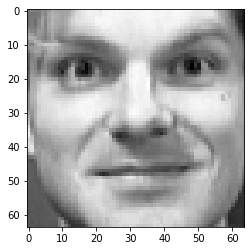

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_dir[0])
plt.imshow(img) # show one sample image
plt.gray()

In [5]:
import numpy as np
X=[]
for img in img_dir:
  a = mpimg.imread(img)
  X.append(a.flatten())
X=np.array(X).T
print(X.shape)  # shape of original dataset

(4096, 30)


In [6]:
import math
def plot(X):
  n,m=X.shape
  fig,axes = plt.subplots(math.ceil(m/5),5,figsize=(20,14))
  axes = axes.ravel()

  for i in range(m):
      axes[i].imshow(np.reshape(X[:,i],(64,64)),cmap='gray')
  #fig.delaxes(axes[-1])

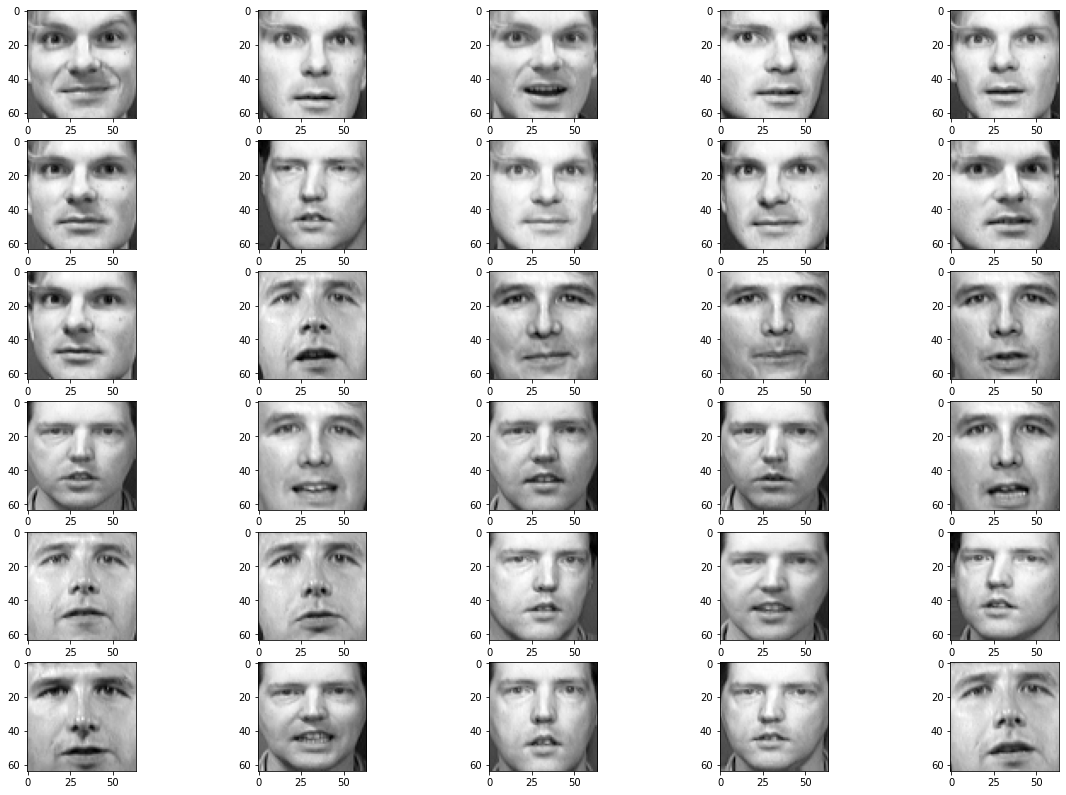

In [7]:
plot(X)  # plot original images

In [8]:
# Normalization
mean=X.mean(axis=1,keepdims=True)
std=X.std(axis=1,keepdims=True)
X_norm=(X-mean)/std

In [9]:
print(X_norm.shape)
print(np.max(X))
print(np.max(X_norm))

(4096, 30)
0.85882354
3.7639132


In [10]:
np.set_printoptions(precision=3) # to limit the calculations
cov = np.cov(X_norm) # create a covariance matrix
print("covariance shape : ",cov.shape)

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)  # Find eigen value and eigen vector of covariance matrix

print("Eigenvalues size:", EigVal.shape,"\n")

covariance shape :  (4096, 4096)
Eigenvalues size: (4096,) 



In [11]:
print("Eigenvector size:", EigVec.shape,"\n")

Eigenvector size: (4096, 4096) 



In [12]:
# Ordering Eigen values and vectors
# arrange the eigen values in descending order
order = EigVal.argsort()[::-1] 
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
EigVec=EigVec.astype(float)
PC = (X_norm.T @ EigVec).T   #cross product

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [13]:
print(PC.shape) # shape of Projected Vector over eigen vectors

(4096, 30)


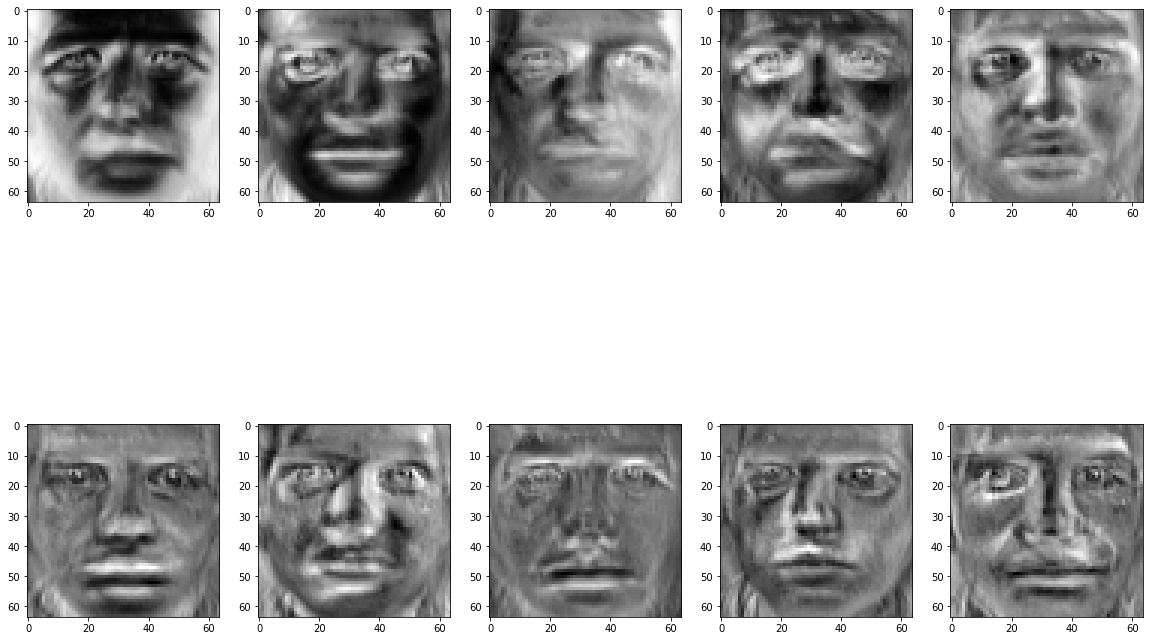

In [14]:
plot(EigVec[:,:10]) # plot first 10 eigen vector to see what they capture

In [15]:
print(EigVec)

[[ 0.023 -0.015 -0.003 ...  0.004  0.004 -0.006]
 [ 0.023 -0.013 -0.008 ...  0.001  0.001 -0.013]
 [ 0.022 -0.009 -0.014 ...  0.008  0.008  0.011]
 ...
 [ 0.017 -0.003  0.015 ...  0.033  0.033 -0.008]
 [ 0.015 -0.001  0.012 ... -0.015 -0.015  0.031]
 [ 0.006  0.001  0.012 ...  0.014  0.014  0.003]]


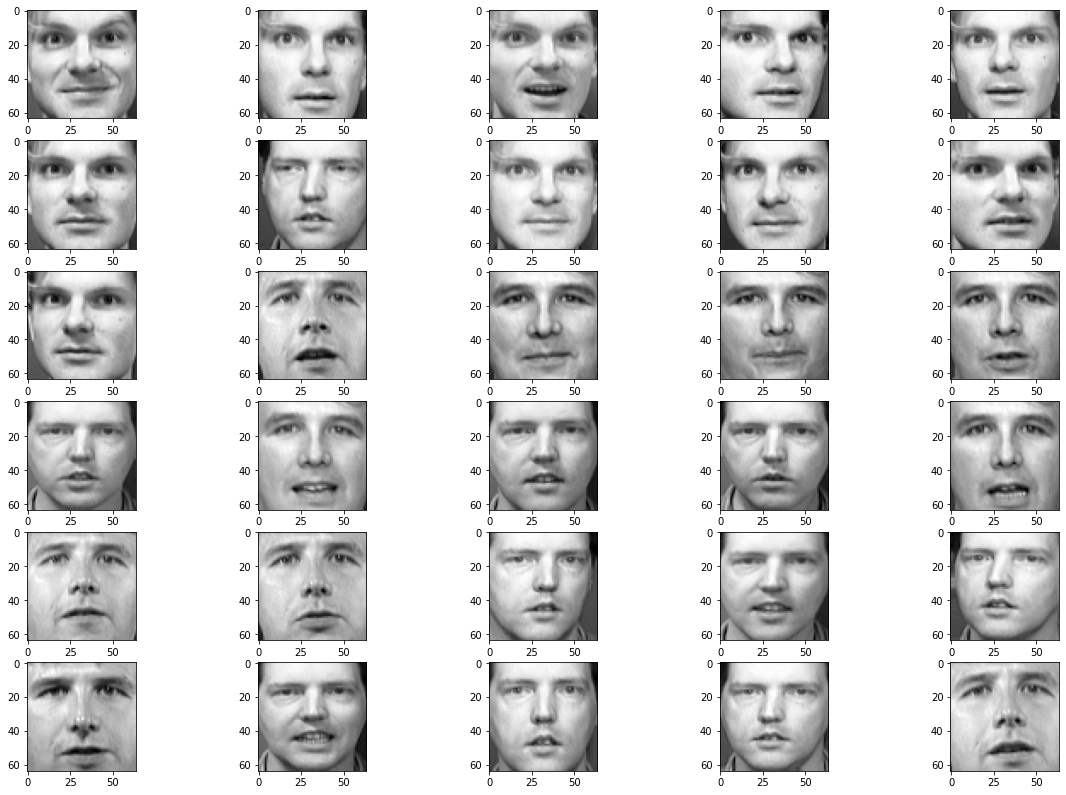

In [16]:
recover = (EigVec @ PC)*std +mean  # reconstruct all images from 4096 dims
plot(recover) # we can see that we got exactly the original datset

In [18]:
def reconstruct(X_norm,EigVec,EigVal,mean,std,n):  # function to compress and then reconstruct
  # Compress the image by taking projection of actual data on first n PCs
  PC = (X_norm.T @ EigVec[:,:n]).T   #cross product
  # PC shape = n x 30

  # Recover the image by taking projection of actual data by cross multiplication of EigVec.T
  recover = (EigVec[:,:n] @ PC)*std + mean  # recover shape = 4096 x 30
  return recover

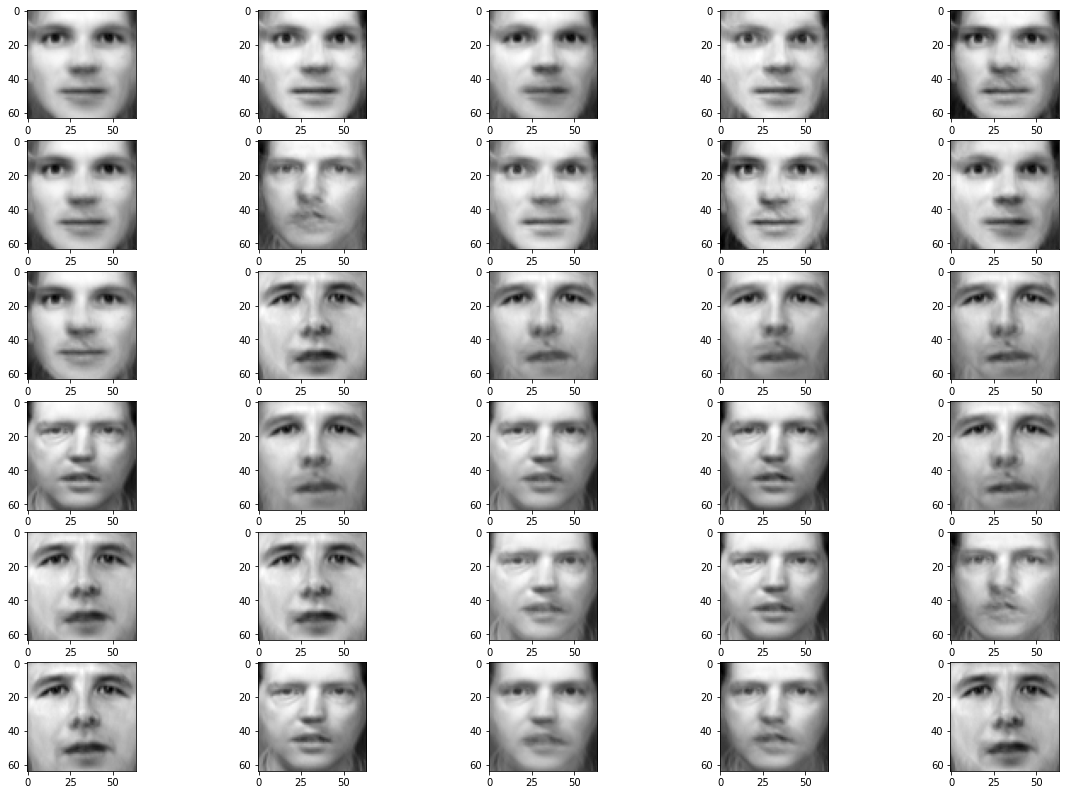

In [19]:
plot(reconstruct(X_norm,EigVec,EigVal,mean,std,3)) # lets do compression and recovery using only 3 dims

/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


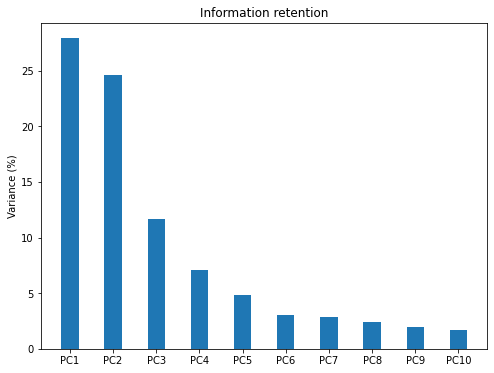

In [22]:
#Information Retained by Principal Components
# Gives a idea how much data is retained by which principal component
plt.figure(figsize=(8,6))
plt.bar([1,2,3,4,5,6,7,8,9,10],(EigVal/sum(EigVal)*100)[:10],align='center',width=0.4,
        tick_label = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])
plt.ylabel('Variance (%)')
plt.title('Information retention');

In [40]:
def compare(EigVec,EigVal,mean,std): # function for visualizing data with different compressions
  X1 = mpimg.imread(os.path.join(dir,"4.png")).reshape(4096,1)
  X2 = mpimg.imread(os.path.join(dir,"11.png")).reshape(4096,1)
  X3 = mpimg.imread(os.path.join(dir,"28.png")).reshape(4096,1)
  X1_norm=(X1-mean)/std
  X2_norm=(X2-mean)/std
  X3_norm=(X3-mean)/std
  print(X1.shape,X1_norm.shape)

  X=[X1,X2,X3]
  N=[X1_norm,X2_norm,X3_norm]
  d=[4096,2000,1000,500,250,100,50,25,15,10,9,8,7,6,5,4,3,2,1,0]
  # d is the dimension to which we compress

  for i in range(20):
    fig,axes = plt.subplots(1,6,figsize=(20,2))
    axes=axes.ravel()
    fig.suptitle(str(d[i]) + " dimensions",fontsize=14)
    for j in range(3):
      # plot the original image
      axes[j*2].imshow(np.reshape(X[j],(64,64)),cmap='gray')
      axes[j*2].set_title("original",fontsize=8)
      # plot the reconstructed image using n dims after projection over 4096 dimensions
      img=reconstruct(N[j],EigVec,EigVal,mean,std,d[i])
      axes[j*2+1].imshow(np.reshape(img,(64,64)),cmap='gray')
      axes[j*2+1].set_title("reconstructed",fontsize=8)
    plt.show()

(4096, 1) (4096, 1)


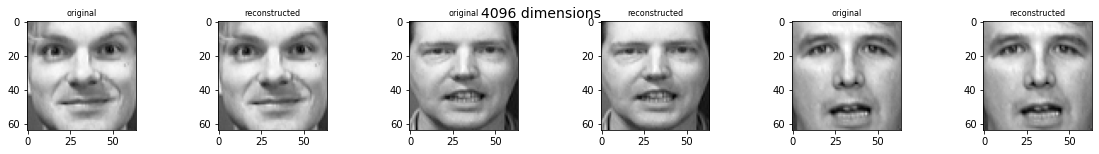

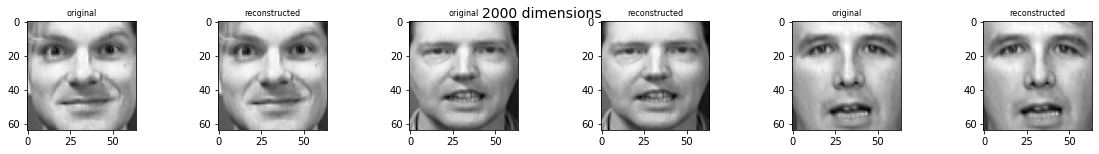

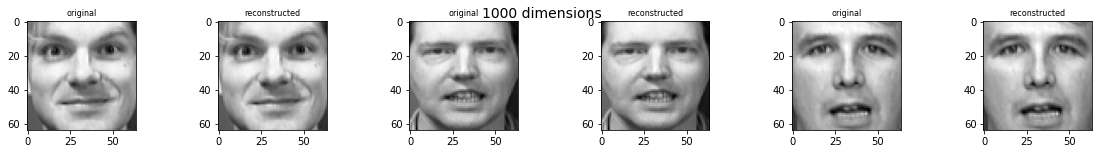

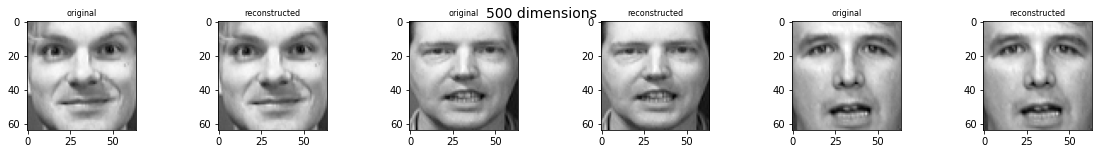

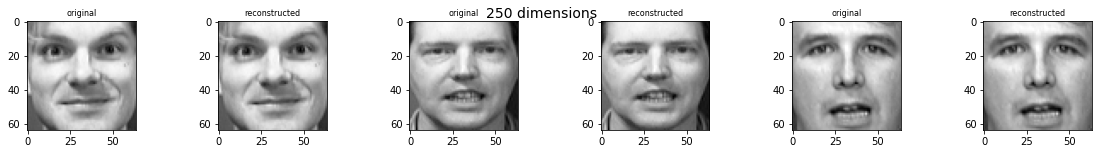

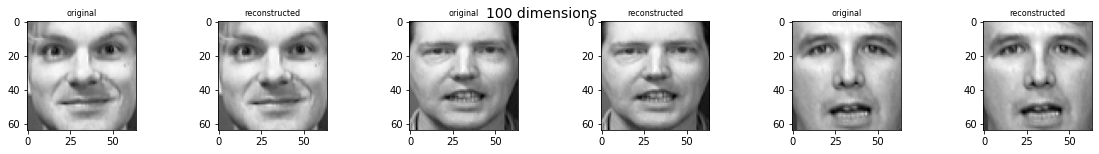

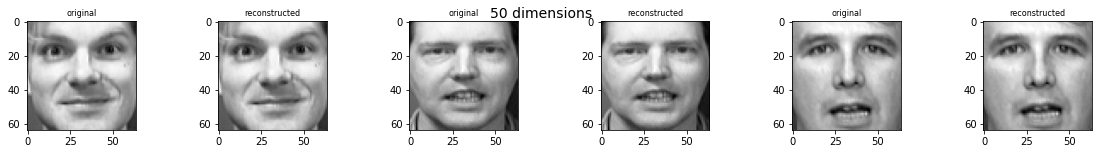

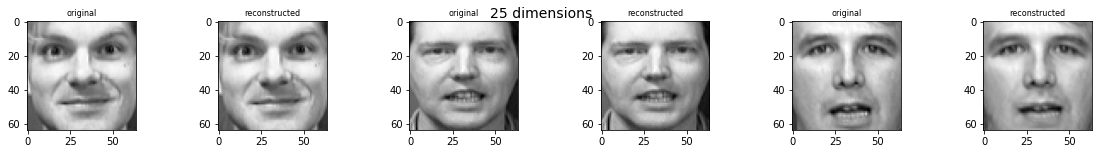

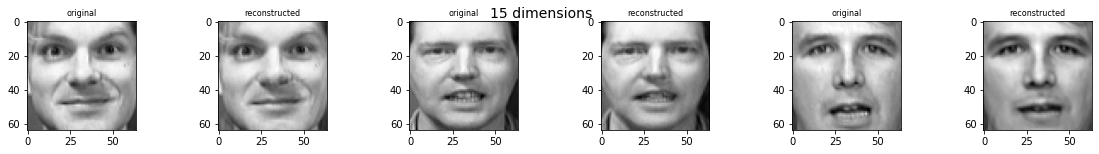

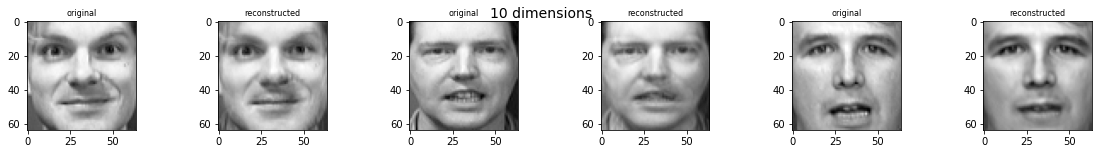

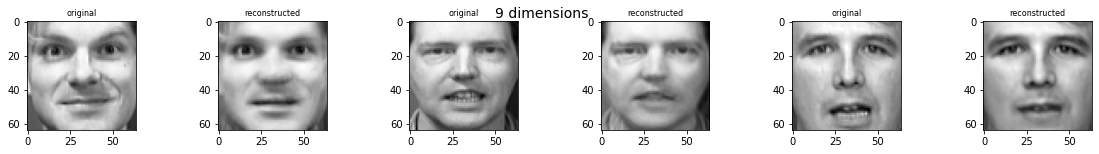

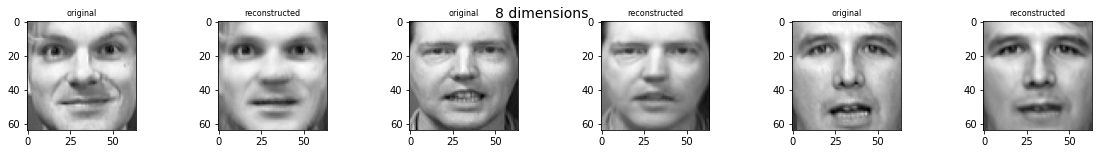

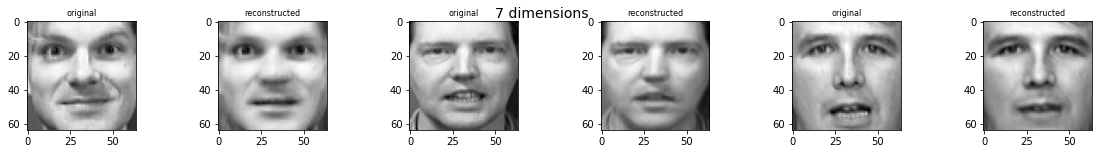

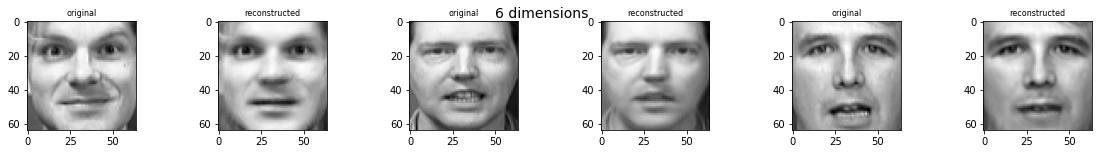

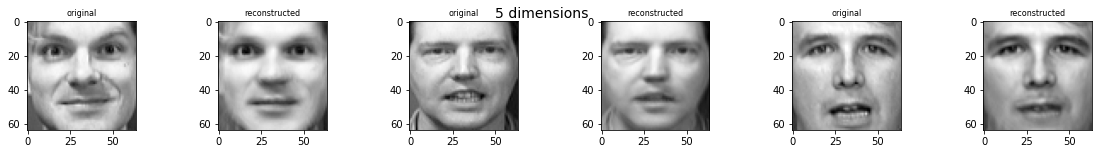

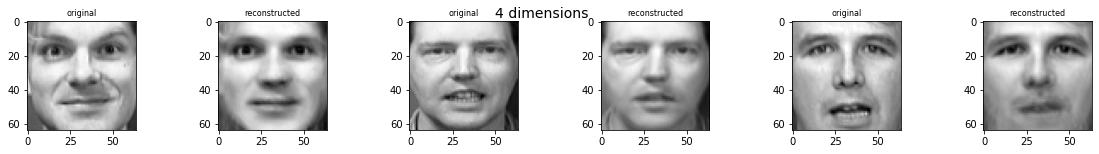

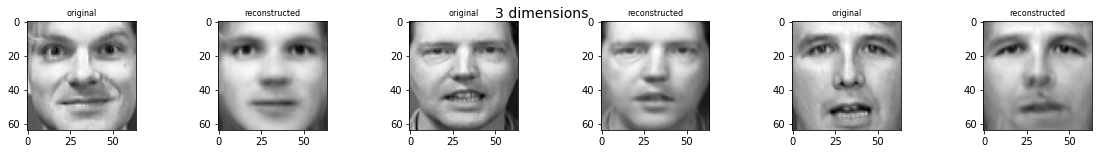

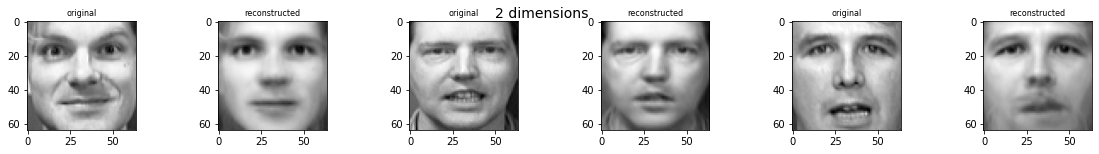

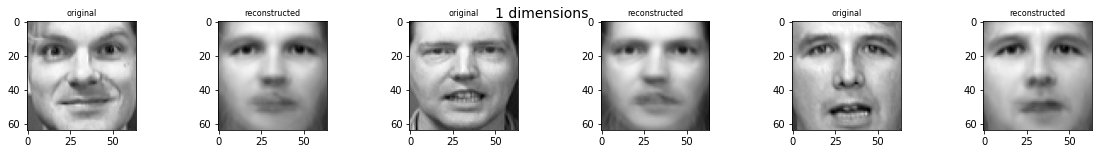

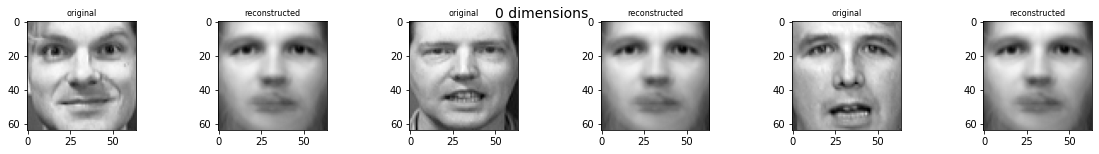

In [41]:
compare(EigVec,EigVal,mean,std)